In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Concatenate, BatchNormalization, Activation, Conv1D, Flatten, Embedding
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
import tensorflow as tf
import keras
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
def auc(y_true, y_pred):
    f1 = lambda: tf.constant(0, dtype=tf.float64)
    f2 = lambda: tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    
    r = tf.case([(tf.equal(tf.reduce_sum(y_true), tf.constant(0, dtype=tf.float32)), f1),
                 (tf.equal(tf.reduce_sum(tf.subtract(tf.ones_like(y_true), y_true)), tf.constant(0, dtype=tf.float32)), f1)
                ], default=f2)
    return r

In [4]:
df_train = pd.read_csv('train_with_counts.csv')
y = df_train['target'].values

In [44]:
columns = [f'var_{v}' for v in range(200)]
columns_FE = [f'var_{v}_FE' for v in range(200)]

In [45]:
df_values = df_train[columns]
df_counts = df_train[columns_FE]

In [49]:
df_values_normalized = (df_values - df_values.mean(axis=0))/df_values.std(axis=0)
#df_counts_normailzed = (df_counts - df_counts.mean(axis=0))/df_counts.std(axis=0)
df_counts_normailzed = df_counts

In [81]:
df_counts_normailzed.max().values

array([  14,   12,   17,   18,   19,   10,   30,   12,   14,   22,   11,
         10,  291,   12,   17,   46,   17,   10,   10,    9,   12,   10,
         14,   39,   12,   60,   11,   20,   32,   14,    9,   20,   16,
         16,   38,   14,   14,   18,   13,   11,   11,   11,   31,   54,
         13,    7,   16,    9,    9,   10,   34,   10,   13,   32,    9,
         11,   15,   29,   12,   28,   11,    7,   18,   13,   21,   11,
         25,   10, 1634,   12,    9,   71,   13,   10,    8,   11,   11,
         13,   22,   22,   10,   18,   10,    9,   10,   13,   10,   12,
         18,   14,    9,   96,   13,   42,   16,   36,    8,    8,   36,
         19,    8,   10,    9,   79,   18,   31,   18,   12,  459,   12,
         14,   25,   21,   11,   25,   17,   19,    9,   10,   13,    8,
         19,   12,   11,   14,   55,  444,   14,   13,   11,   33,   44,
         20,   54,   11,    9,    7,    9,   11,   10,   12,    9,   10,
         16,   31,   13,   19,   10,   83,   10,   

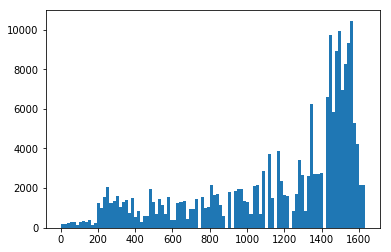

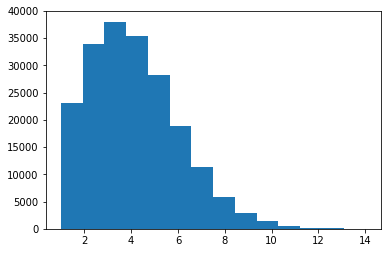

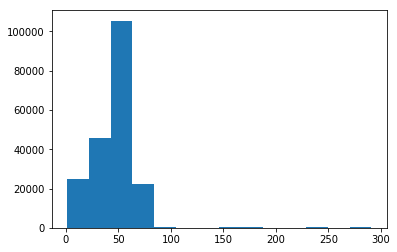

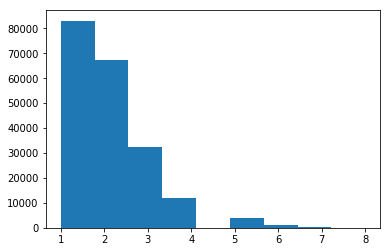

In [99]:
from matplotlib import pyplot as plt
_ = plt.hist(df_counts_normailzed['var_68_FE'].values, 100)
plt.show()
_ = plt.hist(df_counts_normailzed['var_0_FE'].values, 14)
plt.show()
_ = plt.hist(df_counts_normailzed['var_12_FE'].values, 14)
plt.show()
_ = plt.hist(df_counts_normailzed['var_199_FE'].values, 9)
plt.show()

In [70]:
np.max(df_counts_normailzed.values), np.min(df_counts_normailzed.values)

(1634, 1)

In [72]:
np.where(df_counts_normailzed.values == 1634)

(array([   129,    226,    266, ..., 199202, 199347, 199615]),
 array([68, 68, 68, ..., 68, 68, 68]))

In [79]:
df_values_normalized['var_68'].iloc[266]

0.3627117778439802

In [50]:
df_train_X_normalized = pd.concat([df_values_normalized, df_counts_normailzed], axis=1)
df_train_X_normalized.shape

(200000, 400)

In [51]:
df_train_X_normalized.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190_FE,var_191_FE,var_192_FE,var_193_FE,var_194_FE,var_195_FE,var_196_FE,var_197_FE,var_198_FE,var_199_FE
0,-0.577100,-1.273734,0.451706,-0.833707,0.235571,-0.536429,-0.334925,0.608749,-1.561576,-1.473792,...,3,8,9,4,9,5,5,14,5,2
1,0.269958,-0.622136,1.190357,-0.688845,0.790973,1.539897,0.244461,-0.003525,0.858972,0.419299,...,8,5,9,2,4,4,4,21,6,2
2,-0.681112,-0.276066,0.516987,0.536515,-0.305476,-0.511032,1.769834,-0.564748,-1.561366,-1.307405,...,4,5,6,2,2,2,3,12,4,2
3,0.125158,-0.129425,-0.667574,0.195354,0.927990,0.410671,0.500632,-0.474200,-1.843906,0.548765,...,2,3,6,4,4,8,5,4,2,2
4,-0.277303,0.035610,0.817681,-0.077829,0.738605,0.955572,0.613370,0.791542,1.794748,0.090006,...,3,8,1,1,1,9,5,9,2,2


In [52]:
X_train_normalized = np.zeros((df_train_X_normalized.shape[0], 400, 1))
for i in range(200):
    X_train_normalized[:, 2*i] = df_train_X_normalized[[f'var_{i}']].values
    X_train_normalized[:, 2*i+1] = df_train_X_normalized[[f'var_{i}_FE']].values
    # X_train_normalized[:, 3*i+2] = df_train_X_normalized[[f'var_{i}']].values**2

In [54]:
X_train_normalized.shape

(200000, 400, 1)

In [59]:
values = Input(shape=(200,))
counts = Input(shape=(200,))
Embedding()

In [55]:
model = Model()
model.add(Conv1D(200, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(400, 1)))
# model.add(Dense(1, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 200, 200)          600       
_________________________________________________________________
flatten_5 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 40001     
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


In [40]:
def get_model():
    model = Sequential()
    model.add(Conv1D(200, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(400, 1)))
    # model.add(Dense(1, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [41]:
get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 200, 200)          600       
_________________________________________________________________
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 40001     
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


In [42]:
best_model_file_name = 'best_full_model.h5'
# Epoch 00009: val_auc did not improve from 0.91768

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
patience = 15
epochs = 70
bs = 512
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_X_normalized, y)):
    print('###############################################')
    print(f'##################Fold {fold}#######################')
    print('###############################################')
    X_val = df_train_X_normalized.values[val_idx]
    
    print('Got train and val data!')
    lrs = [0.005, 0.0005, 0.0001]
    model = get_model()
    for lr in lrs:
        model.compile(Adam(lr=lr, decay=0), loss='binary_crossentropy', metrics=[auc])
        es = EarlyStopping(monitor='val_auc', patience=patience, mode='max', verbose=1)
        mc = ModelCheckpoint(best_model_file_name, monitor='val_auc', mode='max', verbose=1, save_best_only=True)
        # First train
        model.fit(X_train_normalized[trn_idx], y[trn_idx],
                  epochs=epochs,
                  verbose=0,
                  batch_size=bs,
                  callbacks = [es, 
                               mc], 
                               #clr],
                  validation_data=(X_train_normalized[val_idx], y[val_idx]))
        print(f'Finish training with lr {lr}')
        model = get_model()
        # Load weights from ModelCheckpoint
        model.load_weights(best_model_file_name)
        # Save them to disk
        model.save_weights(f'big_CNN_fold_{fold}_lr_{lr}.hdf5')
        print('weights saved')

###############################################
##################Fold 0#######################
###############################################
Got train and val data!

Epoch 00001: val_auc improved from -inf to 0.89207, saving model to best_full_model.h5

Epoch 00002: val_auc improved from 0.89207 to 0.90474, saving model to best_full_model.h5

Epoch 00003: val_auc improved from 0.90474 to 0.90927, saving model to best_full_model.h5


KeyboardInterrupt: 